# CNN Training Notebook

In [41]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


In [42]:
# Load merged training and validation sets
X_train = np.load("../data/processed/patches_train.npy")
y_train = np.load("../data/processed/labels_train.npy")

X_val = np.load("../data/processed/patches_val.npy")
y_val = np.load("../data/processed/labels_val.npy")

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


(4602, 16, 16) (4602,)
(767, 16, 16) (767,)


In [43]:
# Fix NaN patches
def replace_nan_with_mean(arr):
    arr = arr.copy()
    for i in range(arr.shape[0]):
        patch = arr[i]
        mask = np.isnan(patch)
        if mask.any():
            mean_val = np.nanmean(patch)
            patch[mask] = mean_val
        arr[i] = patch
    return arr

X_train = replace_nan_with_mean(X_train)
X_val   = replace_nan_with_mean(X_val)

print("Any NaN left?", np.isnan(X_train).any(), np.isnan(X_val).any())


Any NaN left? False False


In [44]:
# Compute mean and std from training set only
mean = np.mean(X_train)
std  = np.std(X_train)

print("Mean:", mean, "Std:", std)

# Apply Z-score normalization
X_train = (X_train - mean) / (std + 1e-6)
X_val   = (X_val   - mean) / (std + 1e-6)


Mean: 297.9944 Std: 35.109657


In [45]:
# CNN input shape: (N, 1, 16, 16)
X_train_t = torch.tensor(X_train).unsqueeze(1).float()
X_val_t   = torch.tensor(X_val).unsqueeze(1).float()

y_train_t = torch.tensor(y_train).long()
y_val_t   = torch.tensor(y_val).long()

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)



In [46]:
class UHICNN(nn.Module):
    def __init__(self):
        super(UHICNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x8x8

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x4x4
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = UHICNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [47]:
EPOCHS = 15
train_losses = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct = 0
    total = 0
    vloss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            vloss += loss.item()

            predicted = preds.argmax(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)

    val_losses.append(vloss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Val Acc: {val_accs[-1]:.4f}")


Epoch 1/15 | Train Loss: 0.1794 | Val Loss: 0.0548 | Val Acc: 0.9778
Epoch 2/15 | Train Loss: 0.1082 | Val Loss: 0.0551 | Val Acc: 0.9765
Epoch 3/15 | Train Loss: 0.0953 | Val Loss: 0.0391 | Val Acc: 0.9831
Epoch 4/15 | Train Loss: 0.0939 | Val Loss: 0.0359 | Val Acc: 0.9831
Epoch 5/15 | Train Loss: 0.0832 | Val Loss: 0.0522 | Val Acc: 0.9726
Epoch 6/15 | Train Loss: 0.0805 | Val Loss: 0.0562 | Val Acc: 0.9791
Epoch 7/15 | Train Loss: 0.0738 | Val Loss: 0.0423 | Val Acc: 0.9844
Epoch 8/15 | Train Loss: 0.0668 | Val Loss: 0.0484 | Val Acc: 0.9778
Epoch 9/15 | Train Loss: 0.0643 | Val Loss: 0.0270 | Val Acc: 0.9909
Epoch 10/15 | Train Loss: 0.0592 | Val Loss: 0.0342 | Val Acc: 0.9844
Epoch 11/15 | Train Loss: 0.0568 | Val Loss: 0.0321 | Val Acc: 0.9844
Epoch 12/15 | Train Loss: 0.0503 | Val Loss: 0.0272 | Val Acc: 0.9883
Epoch 13/15 | Train Loss: 0.0482 | Val Loss: 0.0232 | Val Acc: 0.9896
Epoch 14/15 | Train Loss: 0.0441 | Val Loss: 0.0246 | Val Acc: 0.9870
Epoch 15/15 | Train Loss: 0.0

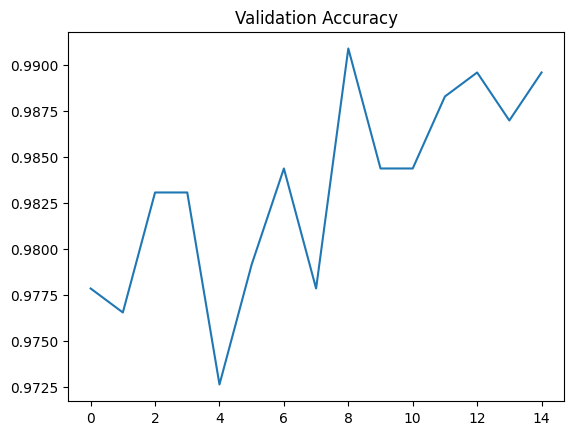

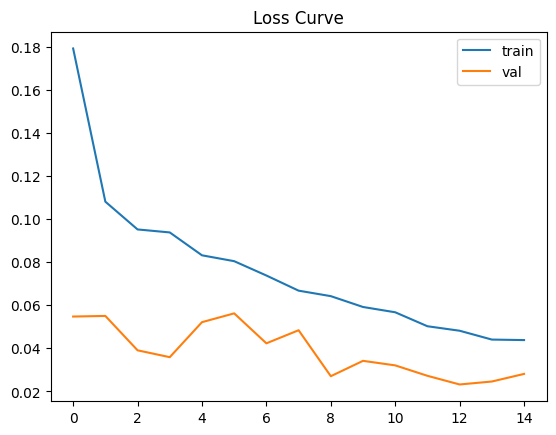

In [48]:
plt.plot(val_accs)
plt.title("Validation Accuracy")
plt.show()

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Loss Curve")
plt.show()


# Confusion Matrix

In [49]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute predictions for the entire validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:
        preds = model(xb).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[418   6]
 [  2 341]]


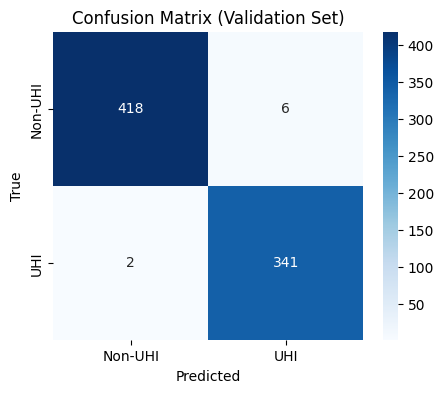

In [50]:
# Visualize confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-UHI", "UHI"],
            yticklabels=["Non-UHI", "UHI"])
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Example Predictions

In [51]:
# Random sample from validation set
import random

# Pick 8 random indices
sample_idx = random.sample(range(len(X_val)), 8)


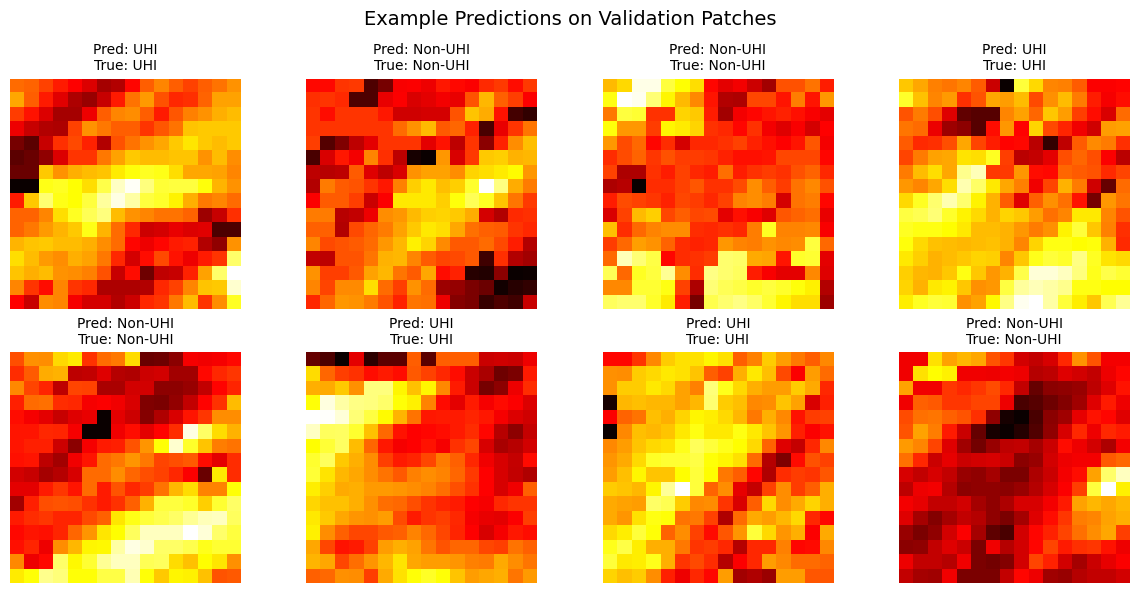

In [52]:
# Plot the sample patches
plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_idx):
    patch = X_val[idx]
    true_label = "UHI" if y_val[idx] == 1 else "Non-UHI"

    # Run model prediction
    patch_tensor = torch.tensor(patch).unsqueeze(0).unsqueeze(0).float()
    pred = model(patch_tensor).argmax(1).item()
    pred_label = "UHI" if pred == 1 else "Non-UHI"

    plt.subplot(2, 4, i+1)
    plt.imshow(patch, cmap="hot")
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis("off")

plt.suptitle("Example Predictions on Validation Patches", fontsize=14)
plt.tight_layout()
plt.show()


# Classification Report

In [53]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds,
                            target_names=["Non-UHI", "UHI"]))


              precision    recall  f1-score   support

     Non-UHI       1.00      0.99      0.99       424
         UHI       0.98      0.99      0.99       343

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



# ROC Curve + AUC

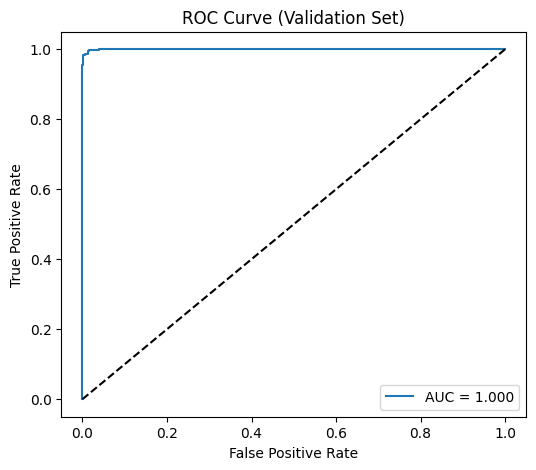

In [54]:
from sklearn.metrics import roc_curve, auc

# Softmax probabilities for ROC
model.eval()
probs = []
true_vals = []

with torch.no_grad():
    for xb, yb in val_loader:
        logits = model(xb)
        prob = torch.softmax(logits, dim=1)[:, 1]  # probability of UHI
        probs.extend(prob.cpu().numpy())
        true_vals.extend(yb.cpu().numpy())

fpr, tpr, _ = roc_curve(true_vals, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Validation Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# Grad-CAM

In [55]:
# Register hook to capture gradients and feature maps
gradients = None
activations = None

def save_gradients(grad):
    global gradients
    gradients = grad

def forward_hook(module, input, output):
    global activations
    activations = output


In [56]:
# Hook the last Conv layer (Conv2)
target_layer = model.conv_layers[3]  
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(lambda m, grad_in, grad_out: save_gradients(grad_out[0]))



In [57]:
def generate_gradcam(patch):
    model.eval()
    x = torch.tensor(patch).unsqueeze(0).unsqueeze(0).float()

    model.zero_grad()
    score = model(x)[:, 1]
    score.backward()

    grad = gradients.detach().cpu()
    act = activations.detach().cpu()

    weights = grad.mean(dim=(2, 3), keepdim=True)      
    cam = (weights * act).sum(dim=1).squeeze(0).numpy()

    cam = np.maximum(cam, 0)
    cam /= cam.max() + 1e-6
    return cam


/opt/anaconda3/envs/uhi/lib/python3.11/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


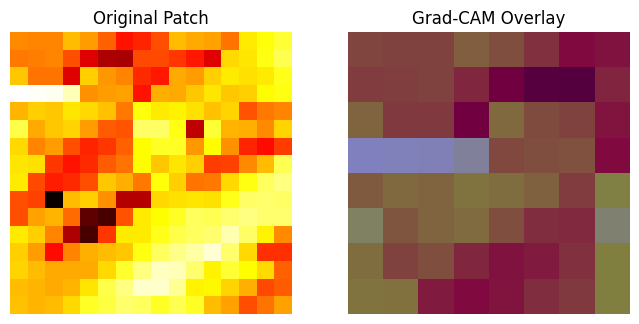

In [58]:
import cv2

def show_gradcam_example(idx):
    patch = X_val[idx]
    true_label = y_val[idx]
    cam = generate_gradcam(patch)

    plt.figure(figsize=(8,4))

    # Original patch
    plt.subplot(1,2,1)
    plt.imshow(patch, cmap='hot')
    plt.title("Original Patch")
    plt.axis("off")

    # Grad-CAM overlay
    plt.subplot(1,2,2)
    plt.imshow(patch, cmap='hot')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")

    plt.show()

# Example: show Grad-CAM for a random validation patch
show_gradcam_example(50)
